<a href="https://colab.research.google.com/github/saisrikanthrayavarapu/CNN/blob/main/Gesture_recognition_assignment_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.io import imread
import datetime
import os
import glob
import cv2
import h5py

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D

In [3]:
# mounting Google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir "/content/Gesture_assignment" # creating a new directory for the unzipped file
!gdown --id "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL" # downloading the zipped file in the session
# https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/Project_data.zip
100% 1.71G/1.71G [00:10<00:00, 165MB/s]


In [5]:
# unzipping the file in the created directory
!unzip -q "/content/Project_data.zip" -d "/content/Gesture_assignment" 

We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
# verifying the GPU configuration
!nvidia-smi

Mon Jan 10 19:32:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
train_doc = np.random.permutation(open('/content/Gesture_assignment/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Gesture_assignment/Project_data/val.csv').readlines())

In [9]:
# curr_dt_time = datetime.datetime.now()
train_path = '/content/Gesture_assignment/Project_data/train'
val_path = '/content/Gesture_assignment/Project_data/val'

In [10]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [11]:
# method to calculate model steps
def n_steps(num_train_sequences, num_val_sequences, batch_size):
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
  return steps_per_epoch,validation_steps

In [12]:
# method to plot model accuracy and loss
def accuracy_loss_plot(history, name):
  f, ax = plt.subplots(1,2, figsize=(10,4))
  ax[1].plot(history.history['loss'])   
  ax[1].plot(history.history['val_loss'])
  ax[1].legend(['loss','val_loss'], loc='upper left')
  ax[1].title.set_text('Loss Plot for '+name)

  ax[0].plot(history.history['categorical_accuracy'])   
  ax[0].plot(history.history['val_categorical_accuracy'])
  ax[0].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')
  ax[0].title.set_text('Accuracy Plot for '+name)
  f.suptitle('Accuracy and Loss plot for '+name, fontweight='bold')
  plt.show()

In [13]:
# method to get model callbacks
def model_callbacks(name):
  dirpath = name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
  if not os.path.exists(dirpath):
    os.mkdir(dirpath)
  filepath = dirpath + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=False, save_weights_only=False, 
                             mode='auto', period=1)
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
  callbacks_list = [checkpoint, LR]
  return dirpath, callbacks_list

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size, n_frames, frame_size_x, frame_size_y):
    print('Source path = ', source_path, '\n batch size =', batch_size,
          '\n No. of images from each folder =', n_frames,
          '\n Normalized image size =', frame_size_x, 'x', frame_size_y)
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int) # since each video is of 30 frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,n_frames,frame_size_x,frame_size_y,3))
            batch_labels = np.zeros((batch_size,5)) # here 5 is the number of gestures
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.resize(image,(frame_size_x,frame_size_x)) # resing the actual image to the defined size
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 # normalizing the image for R channel
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 # normalizing the image for G channel
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 # normalizing the image for B channel    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,n_frames,frame_size_x,frame_size_y,3)) # leftout data after batch sizing
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.resize(image,(frame_size_x,frame_size_x)) # resing the actual image to the defined size
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 # normalizing the image for R channel
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 # normalizing the image for G channel
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 # normalizing the image for B channel
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

## Model

### Model-1 : 3D convolution with 15 frames using an image size of 120x120 with a batch size of 30 run for 30 epochs for convolution layers of (16, 32, 64) and dense layers of (64, 128)

In [15]:
n_frames = 15
frame_size_x = 120
frame_size_y = 120
batch_size = 30
n_epochs = 30

In [16]:
# method to create 3D convolution model
def conv3D_model(conv_layers,dense_layers,dropout,n_frames,frame_size_x,frame_size_y):
  model = Sequential()

  model.add(Conv3D(conv_layers[0], (3, 3, 3), padding='same',
                 input_shape=(n_frames,frame_size_x,frame_size_y,3), 
                 kernel_initializer='he_uniform'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(conv_layers[1], (2, 2, 2), padding='same', kernel_initializer='he_uniform'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(conv_layers[2], (2, 2, 2), padding='same', kernel_initializer='he_uniform'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  # model.add(Conv3D(conv_layers[3], (2, 2, 2), padding='same', kernel_initializer='he_uniform'))
  # model.add(Activation('relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  # model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(dense_layers[1],activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(dense_layers[0],activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(5,activation='softmax')) # number of gestures
  return model

In [17]:
# adding optimizer and summarizing the model-1
model_1 = conv3D_model(conv_layers=(16,32,64,128), dense_layers=(128,64),
                       dropout=0.25, n_frames=n_frames, 
                       frame_size_x=frame_size_x, frame_size_y=frame_size_y)
optimiser = optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 7, 60, 60, 32)     0

In [18]:
# fetching all the parameters for model-1 fitting
train_generator = generator(train_path, train_doc, batch_size, n_frames, frame_size_x, frame_size_y)
val_generator = generator(val_path, val_doc, batch_size, n_frames, frame_size_x, frame_size_y)
model_1_path, callbacks_list = model_callbacks('model_1')
epoch_steps, val_steps = n_steps(num_train_sequences, num_val_sequences, batch_size)

In [19]:
history_1 = model_1.fit_generator(train_generator, steps_per_epoch=epoch_steps,
                                  epochs=n_epochs, callbacks=callbacks_list, 
                                  validation_data=val_generator, validation_steps=val_steps,
                                  class_weight=None, workers=1, initial_epoch=0,
                                  verbose=1)

Source path =  /content/Gesture_assignment/Project_data/train 
 batch size = 30 
 No. of images from each folder = 15 
 Normalized image size = 120 x 120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5557 - categorical_accuracy: 0.4419Source path =  /content/Gesture_assignment/Project_data/val 
 batch size = 30 
 No. of images from each folder = 15 
 Normalized image size = 120 x 120

Epoch 00001: saving model to model_1_2022-01-1019_32_37.215518/model-00001-1.55565-0.44193-2.35516-0.25000.h5
23/23 [==============================] - 50s 2s/step - loss: 1.5557 - categorical_accuracy: 0.4419 - val_loss: 2.3552 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.9880 - categorical_accuracy: 0.5958
Epoch 00002: saving model to model_1_2022-01-1019_32_37.215518/model-00002-0.98803-0.59578-1.63047-0.35000.h5
23/23 [==============================] - 38s 2s/step - loss: 0.9880 - categorical_accuracy: 0.5958 - val_loss: 1.6305 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.7327 - categor

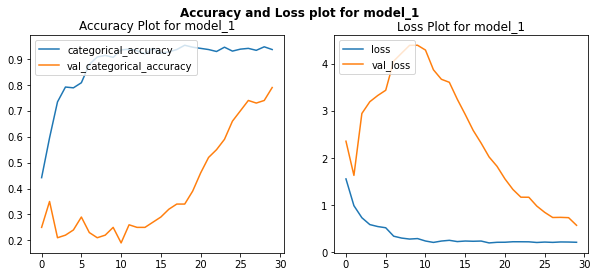

In [20]:
# plotting the history for model_1
accuracy_loss_plot(history_1, 'model_1')

In [21]:
# # # downloading the final h5 file from model_1
# # from google.colab import files

# file_list = glob.glob(model_1_path)
# f =max(file_list, key=os.path.getctime)
# # files.download(max(file_list, key=os.path.getctime)) 
# file_model_1 = h5py.File(f, 'r')
# dset = file_model_1['key']
# data = np.array(dset[:,:,:])
# file_1 = 'test.jpg'
# cv2.imwrite(file_1, data)
# cv2.imshow(file_1)

### Model-2 : 3D convolution with 15 frames using an image size of 120x120 with a batch size of 30 run for 30 epochs for convolution layers of (32, 64, 128) and dense layers of (256, 256) using kernal initializer

In [27]:
n_frames = 15
frame_size_x = 120
frame_size_y = 120
batch_size = 30
n_epochs = 30

In [28]:
# adding optimizer and summarizing the model-2
model_2 = conv3D_model(conv_layers=(32,64,128), dense_layers=(256,256),
                       dropout=0.25, n_frames=n_frames, 
                       frame_size_x=frame_size_x, frame_size_y=frame_size_y)
optimiser = optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 32)  2624      
                                                                 
 activation_6 (Activation)   (None, 15, 120, 120, 32)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 15, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 60, 60, 64)     16448     
                                                                 
 activation_7 (Activation)   (None, 7, 60, 60, 64)    

In [29]:
# fetching all the parameters for model-2 fitting
train_generator = generator(train_path, train_doc, batch_size, n_frames, frame_size_x, frame_size_y)
val_generator = generator(val_path, val_doc, batch_size, n_frames, frame_size_x, frame_size_y)
model_2_path, callbacks_list = model_callbacks('model_2')
epoch_steps, val_steps = n_steps(num_train_sequences, num_val_sequences, batch_size)

In [30]:
history_2 = model_2.fit_generator(train_generator, steps_per_epoch=epoch_steps,
                                  epochs=n_epochs, callbacks=callbacks_list, 
                                  validation_data=val_generator, validation_steps=val_steps,
                                  class_weight=None, workers=1, initial_epoch=0,
                                  verbose=1)

Source path =  /content/Gesture_assignment/Project_data/train 
 batch size = 30 
 No. of images from each folder = 15 
 Normalized image size = 120 x 120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.3623 - categorical_accuracy: 0.5204Source path =  /content/Gesture_assignment/Project_data/val 
 batch size = 30 
 No. of images from each folder = 15 
 Normalized image size = 120 x 120

Epoch 00001: saving model to model_2_2022-01-1019_58_02.080014/model-00001-1.36231-0.52036-2.78702-0.25000.h5
23/23 [==============================] - 43s 2s/step - loss: 1.3623 - categorical_accuracy: 0.5204 - val_loss: 2.7870 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.5939 - categorical_accuracy: 0.7738
Epoch 00002: saving model to model_2_2022-01-1019_58_02.080014/model-00002-0.59391-0.77376-2.29721-0.22000.h5
23/23 [==============================] - 40s 2s/step - loss: 0.5939 - categorical_accuracy: 0.7738 - val_loss: 2.2972 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.4075 - categor

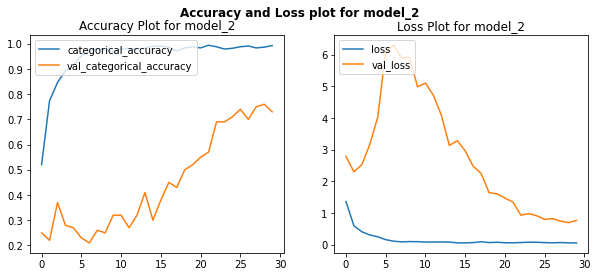

In [31]:
# plotting the history for model_2
accuracy_loss_plot(history_2, 'model_2')

### Model-3 : 3D convolution with 18 frames using an image size of 160x160 with a batch size of 64 run for 10 epochs for convolution layers of (64, 128, 256) and dense layers of (256, 512) using kernal initializer

In [32]:
n_frames = 18
frame_size_x = 160
frame_size_y = 160
batch_size = 20
n_epochs = 20

In [33]:
# adding optimizer and summarizing the model-3
model_3 = conv3D_model(conv_layers=(16,32,64), dense_layers=(128,256),
                       dropout=0.5, n_frames=n_frames, 
                       frame_size_x=frame_size_x, frame_size_y=frame_size_y)
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 18, 160, 160, 16)  1312      
                                                                 
 activation_9 (Activation)   (None, 18, 160, 160, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 18, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 9, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 9, 80, 80, 32)     4128      
                                                                 
 activation_10 (Activation)  (None, 9, 80, 80, 32)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [34]:
# fetching all the parameters for model-3 fitting
train_generator = generator(train_path, train_doc, batch_size, n_frames, frame_size_x, frame_size_y)
val_generator = generator(val_path, val_doc, batch_size, n_frames, frame_size_x, frame_size_y)
model_3_path, callbacks_list = model_callbacks('model_3')
epoch_steps, val_steps = n_steps(num_train_sequences, num_val_sequences, batch_size)

In [35]:
history_3 = model_3.fit_generator(train_generator, steps_per_epoch=epoch_steps,
                                  epochs=n_epochs, callbacks=callbacks_list, 
                                  validation_data=val_generator, validation_steps=val_steps,
                                  class_weight=None, workers=1, initial_epoch=0,
                                  verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/Gesture_assignment/Project_data/train 
 batch size = 20 
 No. of images from each folder = 18 
 Normalized image size = 160 x 160
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8693 - categorical_accuracy: 0.3891Source path =  /content/Gesture_assignment/Project_data/val 
 batch size = 20 
 No. of images from each folder = 18 
 Normalized image size = 160 x 160

Epoch 00001: saving model to model_3_2022-01-1020_18_27.112764/model-00001-1.86928-0.38914-2.46021-0.19000.h5
34/34 [==============================] - 64s 2s/step - loss: 1.8693 - categorical_accuracy: 0.3891 - val_loss: 2.4602 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3478 - categorical_accuracy: 0.5535
Epoch 00002: saving model to model_3_2022-01-1020_18_27.112764/model-00002-1.34775-0.55354-2.81917-0.21000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.3478 - categorical_accuracy: 0.55

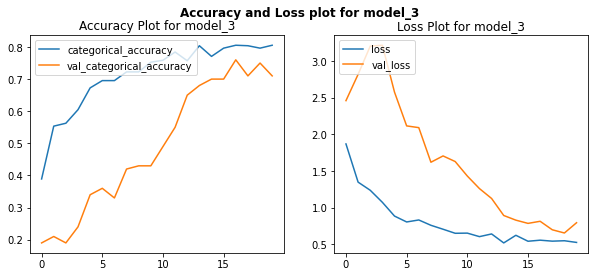

In [36]:
# plotting the history for model_3
accuracy_loss_plot(history_3, 'model_3')

### Model-4 : TimeDistributed, GRU using RNN structures for Transfer Learning on VGG16 Imagenet. Image size is 120x120 for 16 frames execued over 30 epochs using a batch sie of 16

In [37]:
n_frames = 16
frame_size_x = 120
frame_size_y = 120
batch_size = 16
n_epochs = 30

In [38]:
# create a base transfer model and 
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(frame_size_x,frame_size_y,3)) # base model
conv_model = Model(inputs=base_model.input, outputs=Dense(64, activation='relu')(Flatten()(base_model.output))) # convolution output from base model
for layer in base_model.layers:
  layer.trainable = False

# method to create TimeDistributed 2D conv model using GRU cells
def gru_model(conv_layer, dense_layer, dropout, conv_model, n_frames, frame_size_x, frame_size_y):
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(n_frames,frame_size_x,frame_size_y,3)))
  model.add(GRU(conv_layer[0], return_sequences=True))
  model.add(GRU(conv_layer[1]))
  model.add(Dropout(dropout))
  model.add(Dense(dense_layer, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

# method to create TimeDistributed 2D conv model using LSTM cells
def lstm_model(conv_layer, dense_layer, dropout, conv_model, n_frames, frame_size_x, frame_size_y):
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(n_frames,frame_size_x,frame_size_y,3)))
  model.add(LSTM(conv_layer[0], return_sequences=True))
  model.add(LSTM(conv_layer[1]))
  model.add(Dropout(dropout))
  model.add(Dense(dense_layer, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

58900480/58889256 [==============================] - 1s 0us/step


In [39]:
# adding optimizer and summarizing the model-4
model_4 = gru_model(conv_layer=(32,16), dense_layer=8,
                       dropout=0.5, conv_model=conv_model, n_frames=n_frames, 
                       frame_size_x=frame_size_x, frame_size_y=frame_size_y)
optimiser = optimizers.Adam()
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 16, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 5)                 45        
                                                      

In [40]:
# fetching all the parameters for model-4 fitting
train_generator = generator(train_path, train_doc, batch_size, n_frames, frame_size_x, frame_size_y)
val_generator = generator(val_path, val_doc, batch_size, n_frames, frame_size_x, frame_size_y)
model_4_path, callbacks_list = model_callbacks('model_4')
epoch_steps, val_steps = n_steps(num_train_sequences, num_val_sequences, batch_size)

In [41]:
history_4 = model_4.fit_generator(train_generator, steps_per_epoch=epoch_steps,
                                  epochs=n_epochs, callbacks=callbacks_list, 
                                  validation_data=val_generator, validation_steps=val_steps,
                                  class_weight=None, workers=1, initial_epoch=0,
                                  verbose=1)

Source path =  /content/Gesture_assignment/Project_data/train 
 batch size = 16 
 No. of images from each folder = 16 
 Normalized image size = 120 x 120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.5976 - categorical_accuracy: 0.2232Source path =  /content/Gesture_assignment/Project_data/val 
 batch size = 16 
 No. of images from each folder = 16 
 Normalized image size = 120 x 120

Epoch 00001: saving model to model_4_2022-01-1020_36_41.679763/model-00001-1.59757-0.22323-1.54216-0.41000.h5
42/42 [==============================] - 102s 2s/step - loss: 1.5976 - categorical_accuracy: 0.2232 - val_loss: 1.5422 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.4891 - categorical_accuracy: 0.3258
Epoch 00002: saving model to model_4_2022-01-1020_36_41.679763/model-00002-1.48908-0.32579-1.34921-0.51000.h5
42/42 [==============================] - 44s 1s/step - loss: 1.4891 - categorical_accuracy: 0.3258 - val_loss: 1.3492 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.3871 - catego

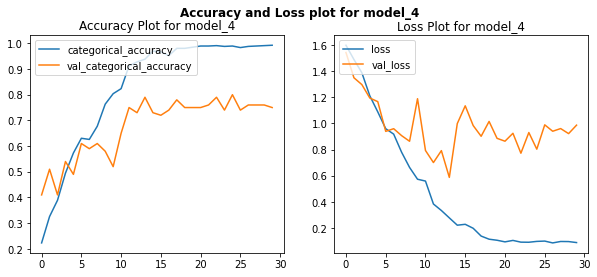

In [42]:
# plotting the history for model_4
accuracy_loss_plot(history_4, 'model_4')

### Model-5 : TimeDistributed, LSTM using RNN structures for Transfer Learning on VGG16 Imagenet. Image size is 120x120 for 16 frames execued over 30 epochs using a batch sie of 16

In [43]:
n_frames = 16
frame_size_x = 120
frame_size_y = 120
batch_size = 16
n_epochs = 30

In [44]:
# adding optimizer and summarizing the model-5
model_5 = lstm_model(conv_layer=(32,16), dense_layer=8,
                       dropout=0.5, conv_model=conv_model, n_frames=n_frames, 
                       frame_size_x=frame_size_x, frame_size_y=frame_size_y)
optimiser = optimizers.Adam()
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 16, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 16, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 5)                 45        
                                                      

In [45]:
# fetching all the parameters for model-5 fitting
train_generator = generator(train_path, train_doc, batch_size, n_frames, frame_size_x, frame_size_y)
val_generator = generator(val_path, val_doc, batch_size, n_frames, frame_size_x, frame_size_y)
model_5_path, callbacks_list = model_callbacks('model_5')
epoch_steps, val_steps = n_steps(num_train_sequences, num_val_sequences, batch_size)

In [46]:
history_5 = model_5.fit_generator(train_generator, steps_per_epoch=epoch_steps,
                                  epochs=n_epochs, callbacks=callbacks_list, 
                                  validation_data=val_generator, validation_steps=val_steps,
                                  class_weight=None, workers=1, initial_epoch=0,
                                  verbose=1)

Source path =  /content/Gesture_assignment/Project_data/train 
 batch size = 16 
 No. of images from each folder = 16 
 Normalized image size = 120 x 120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.3508 - categorical_accuracy: 0.4796Source path =  /content/Gesture_assignment/Project_data/val 
 batch size = 16 
 No. of images from each folder = 16 
 Normalized image size = 120 x 120

Epoch 00001: saving model to model_5_2022-01-1020_59_39.175287/model-00001-1.35078-0.47964-1.16978-0.69000.h5
42/42 [==============================] - 50s 1s/step - loss: 1.3508 - categorical_accuracy: 0.4796 - val_loss: 1.1698 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.9296 - categorical_accuracy: 0.7285
Epoch 00002: saving model to model_5_2022-01-1020_59_39.175287/model-00002-0.92962-0.72851-1.02363-0.70000.h5
42/42 [==============================] - 44s 1s/step - loss: 0.9296 - categorical_accuracy: 0.7285 - val_loss: 1.0236 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.6749 - categor

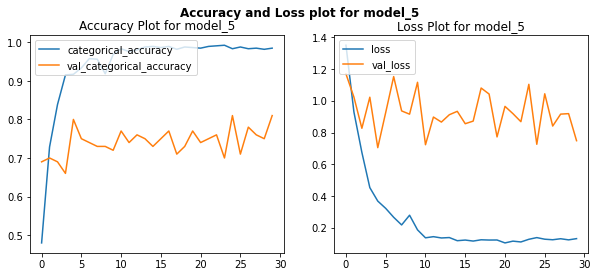

In [47]:
# plotting the history for model_5
accuracy_loss_plot(history_5, 'model_5')

### Model-6 : 3D convolution + LSTM on a frame size of 64x64 for a batch size of 30 executed for 15 epochs with a frame rate of 16.

In [48]:
n_frames = 16
frame_size_x = 64
frame_size_y = 64
batch_size = 30
n_epochs = 15

In [49]:
# creating a model with Conv3D and ConvLSTM2D
model_6 = Sequential()

model_6.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu',
                 input_shape=(n_frames,frame_size_x,frame_size_y,3)))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_6.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu',
                 input_shape=(n_frames,frame_size_x,frame_size_y,3)))
model_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_6.add(ConvLSTM2D(40, (3, 3)))
model_6.add(Flatten())

model_6.add(Dense(128, activation='relu'))
model_6.add(Dropout(0.3))
model_6.add(Dense(5, activation='softmax')) #output layer

optimiser = optimizers.Adam(lr=0.001)
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 64, 64, 32)    2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 32, 32, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 16, 16, 64)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 14, 14, 40)        149920    
                                                                 
 flatten_5 (Flatten)         (None, 7840)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
# fetching all the parameters for model-6 fitting
train_generator = generator(train_path, train_doc, batch_size, n_frames, frame_size_x, frame_size_y)
val_generator = generator(val_path, val_doc, batch_size, n_frames, frame_size_x, frame_size_y)
model_6_path, callbacks_list = model_callbacks('model_6')
epoch_steps, val_steps = n_steps(num_train_sequences, num_val_sequences, batch_size)

In [51]:
history_6 = model_6.fit_generator(train_generator, steps_per_epoch=epoch_steps,
                                  epochs=n_epochs, callbacks=callbacks_list, 
                                  validation_data=val_generator, validation_steps=val_steps,
                                  class_weight=None, workers=1, initial_epoch=0,
                                  verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/Gesture_assignment/Project_data/train 
 batch size = 30 
 No. of images from each folder = 16 
 Normalized image size = 64 x 64
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6169 - categorical_accuracy: 0.2142Source path =  /content/Gesture_assignment/Project_data/val 
 batch size = 30 
 No. of images from each folder = 16 
 Normalized image size = 64 x 64

Epoch 00001: saving model to model_6_2022-01-1021_22_06.410967/model-00001-1.61692-0.21418-1.52850-0.23000.h5
23/23 [==============================] - 38s 2s/step - loss: 1.6169 - categorical_accuracy: 0.2142 - val_loss: 1.5285 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.4888 - categorical_accuracy: 0.3213
Epoch 00002: saving model to model_6_2022-01-1021_22_06.410967/model-00002-1.48882-0.32127-1.41052-0.43000.h5
23/23 [==============================] - 35s 2s/step - loss: 1.4888 - categorical_accuracy: 0.3213 -

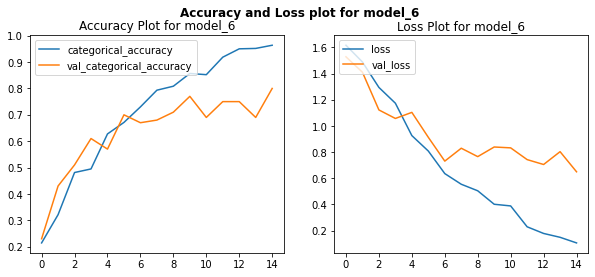

In [52]:
# plotting the history for model_6
accuracy_loss_plot(history_6, 'model_6')